In [1]:
import pandas as pd
import numpy as np
import statistics as stat
import math
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau

In [2]:
def read_ratings():
    names = ['userId', 'movieId', 'rating', 'timestamp']
    df = pd.read_csv('./ml-100k/u.data', '\t', names=names,
                       engine='python')
    
    print(df)
    
    num_users = df.userId.unique().shape[0]
    num_items = df.movieId.unique().shape[0]
    return df, num_users, num_items


ratings, num_users, num_items = read_ratings()

movies = pd.read_csv (r'./ml-latest-small/movies.csv')
ratings = ratings.drop(columns = ["timestamp"])
movies = movies.drop(columns = ["genres"])

/var/folders/gt/99_lr5zn3t39xhj_hs7ksbmc0000gn/T/ipykernel_23336/1352710992.py:13: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  ratings, num_users, num_items = read_ratings()


       userId  movieId  rating  timestamp
0         196      242       3  881250949
1         186      302       3  891717742
2          22      377       1  878887116
3         244       51       2  880606923
4         166      346       1  886397596
...       ...      ...     ...        ...
99995     880      476       3  880175444
99996     716      204       5  879795543
99997     276     1090       1  874795795
99998      13      225       2  882399156
99999      12      203       3  879959583

[100000 rows x 4 columns]


In [3]:
def create_userX_matrix(userId):
    userX_matrix = ratings.query('userId == @userId',inplace = False)
    return userX_matrix

def user_subset_common_movie(userId):
    userX_matrix = create_userX_matrix(userId)
    users = ratings[ratings['movieId'].isin(userX_matrix['movieId'].tolist())]
    userSubsetGroup = users.groupby(['userId'])
    userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]) and len(x[1]) > 50, reverse=True)
    return userSubsetGroup, userX_matrix

def pearsonCorr(inputMovies, similarUsersGroup):
    pearsonCorrelationDict = {}
    for name, group in similarUsersGroup:
        group = group.sort_values(by='movieId')
        inputMovies1 = inputMovies.sort_values(by='movieId')
        temp_df = inputMovies1[inputMovies1['movieId'].isin(group['movieId'].tolist())]
        selectedUserTempRatingList = temp_df['rating'].tolist()
        similarUserTempRatingList = group['rating'].tolist()

        simXX = 0
        meanSelectedUserTempRating = stat.mean(selectedUserTempRatingList)
        for i in selectedUserTempRatingList:
            simXX = simXX + pow((i - meanSelectedUserTempRating),2)
        simYY = 0
        meanSimilarUserTempRaning = stat.mean(similarUserTempRatingList)
        for j in similarUserTempRatingList:
            simYY = simYY + pow((j - meanSimilarUserTempRaning),2)
        simXY = 0
        for i, j in zip(selectedUserTempRatingList, similarUserTempRatingList):
            simXY = simXY+ ((i - meanSelectedUserTempRating ) * (j-meanSimilarUserTempRaning))

        if simXX != 0 and simYY != 0:
            pearsonCorrelationDict[name] = simXY/np.sqrt(simXX*simYY)
        else:
            pearsonCorrelationDict[name] = 0                    
    
    maxSimilarUser = dict(sorted(pearsonCorrelationDict.items(), key=lambda item: item[1], reverse= True))
    return maxSimilarUser

def produceRec (inputMovies, pearsonCorrelationDict):
    similarityScoreofSimilarUsers_data = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
    similarityScoreofSimilarUsers_data.head()
    similarityScoreofSimilarUsers_data.columns = ['similarityScore']
    similarityScoreofSimilarUsers_data['userId'] = similarityScoreofSimilarUsers_data.index
    similarityScoreofSimilarUsers_data.index = range(len(similarityScoreofSimilarUsers_data))
    topSimilarUsers=similarityScoreofSimilarUsers_data.sort_values(by='similarityScore', ascending=False)
    topSimilarUsersRating = topSimilarUsers.merge(ratings, left_on='userId', right_on='userId', how='inner')
    topSimilarUsersRating.head()
    meanRb = topSimilarUsersRating.groupby('userId').mean()[['rating']]
    meanRb.columns = ['avgRating']
    meanRb['userId'] = meanRb.index
    meanRb.index = range(len(meanRb))
    topSimilarUsersRating = topSimilarUsersRating.merge(meanRb, left_on='userId', right_on='userId', how='inner')
    topSimilarUsersRating['weightedRatingScore'] = topSimilarUsersRating['similarityScore']*(topSimilarUsersRating['rating']-topSimilarUsersRating['avgRating'])
    tempTopSimilarUsersRating = topSimilarUsersRating.groupby('movieId').sum()[['weightedRatingScore']]
    tempTopSimilarUsersRating.columns = ['sum_weightedRatingScore']
    tempTopSimilarUsersRating['movieId'] = tempTopSimilarUsersRating.index
    

    recommendation_data = pd.DataFrame()
    meanRa = inputMovies['rating'].mean()
    recommendation_data['weighted average recommendation score'] = meanRa+(tempTopSimilarUsersRating['sum_weightedRatingScore']/topSimilarUsers['similarityScore'].sum())
    recommendation_data['movieId'] = recommendation_data.index
    recommendation_data = recommendation_data.sort_values(by='weighted average recommendation score', ascending=False)
    recommendation_data.index = [x for x in range(1,len(recommendation_data)+1)]
    recommendation_data = recommendation_data.rename(columns=  {'weighted average recommendation score': 'scores'})
    return recommendation_data

In [4]:
userA = 15
userSubsetGroupA, userAMatrix = user_subset_common_movie(userA)
pearsonCorrelationDictA = pearsonCorr(userAMatrix, userSubsetGroupA)
recMovieA = produceRec(userAMatrix, pearsonCorrelationDictA)

In [5]:
pearsonCorrelationDictA

{15: 1.0,
 51: 1.0,
 218: 1.0,
 225: 1.0,
 358: 1.0,
 700: 1.0,
 369: 0.9999999999999999,
 685: 0.9486832980505138,
 609: 0.9119666486866895,
 607: 0.9045340337332909,
 273: 0.8910421112136305,
 352: 0.8626621856275073,
 480: 0.8583950752789522,
 623: 0.8295200860455796,
 245: 0.8293412289143033,
 322: 0.7881603609443285,
 317: 0.7777777777777778,
 585: 0.7745966692414834,
 528: 0.7696656536217926,
 638: 0.7668869461110862,
 331: 0.7659900395832446,
 440: 0.7653749516204769,
 167: 0.7637626158259733,
 481: 0.7592566023652967,
 476: 0.7559289460184545,
 414: 0.7367883976130072,
 496: 0.6900345025877156,
 462: 0.6900012281983666,
 898: 0.6882472016116852,
 511: 0.686406472983644,
 482: 0.6835990727814747,
 111: 0.6802106785137816,
 219: 0.6780026783960365,
 415: 0.6711560552140243,
 836: 0.6681531047810609,
 103: 0.6672974509750947,
 377: 0.6565321642986128,
 826: 0.6377928041432808,
 810: 0.629478829699943,
 475: 0.6261970064069636,
 473: 0.6219993759516246,
 556: 0.6211299937499415,
 7

In [6]:
userB = 685
userSubsetGroupB, userBMatrix = user_subset_common_movie(userB)
pearsonCorrelationDictB = pearsonCorr(userBMatrix, userSubsetGroupB)
recMovieB = produceRec(userBMatrix, pearsonCorrelationDictB)


userC = 245
userSubsetGroupC, userCMatrix = user_subset_common_movie(userC)
pearsonCorrelationDictC = pearsonCorr(userCMatrix, userSubsetGroupC)
recMovieC = produceRec(userCMatrix, pearsonCorrelationDictC)

In [7]:
aL = recMovieA['movieId'].tolist()
bL = recMovieB['movieId'].tolist()
cL = recMovieC['movieId'].tolist()

commonRecMov = set(aL) & set(bL) & set(cL)

recA = recMovieA[recMovieA['movieId'].isin(commonRecMov)]
recB = recMovieB[recMovieB['movieId'].isin(commonRecMov)]
recC = recMovieC[recMovieC['movieId'].isin(commonRecMov)]

#aggregating the three user's recommendation with averaging method
frames = [recA, recB, recC]
result = pd.concat(frames)
GrAv = result.groupby(['movieId'], as_index= False).mean().sort_values(by='scores', ascending=False)
GrAv.index = [x for x in range(1, len(GrAv)+1)]
GrAv['title'] = GrAv['movieId'].map(movies['title'])
top20Av1 = GrAv.head(20)
list20Av1Mov = top20Av1['movieId'].tolist()
top20Av1

#showing the top 20 reccommended movie for average aggregation method
#20 recommended movies for the first iteration     

,movieId,scores,title
1,269,5.412835,Rent-a-Kid (1995)
2,302,5.190579,Ace Ventura: Pet Detective (1994)
3,325,4.182236,"Mask, The (1994)"
4,324,4.096287,Wes Craven's New Nightmare (Nightmare on Elm S...
5,50,3.576035,Georgia (1995)
6,289,3.543758,Tom & Viv (1994)
7,183,3.453709,Before Sunrise (1995)
8,98,3.443679,Taxi Driver (1976)
9,100,3.349766,Before and After (1996)
10,150,3.343509,Love & Human Remains (1993)


In [8]:
def alpha_score(userARec, userBRec, userCRec, GroupRec):
    
    list20Mov = GroupRec['movieId'].tolist()
    satUserA = np.sum(GroupRec['scores'])/np.sum(userARec[userARec['movieId'].isin(list20Mov)]['scores'])
    satUserB = np.sum(GroupRec['scores'])/np.sum(userBRec[userBRec['movieId'].isin(list20Mov)]['scores'])
    satUserC = np.sum(GroupRec['scores'])/np.sum(userCRec[userCRec['movieId'].isin(list20Mov)]['scores'])
    satUsersList = [satUserA, satUserB, satUserC]
    alpha = np.std(satUsersList)
    group_sat = np.mean(satUsersList)
    group_dis = np.max(satUsersList) - np.min(satUsersList)
    
    print(f'User A sat.Score: {satUserA}')
    print(f'User B sat.Score: {satUserB}')
    print(f'User C sat.Score: {satUserC}')
    print(f'Group satisfaction score: {group_sat}')
    
    print(f'Group satisfaction standard deviation / alpha: {alpha}')

    return satUserA, satUserB, satUserC, alpha, group_sat, group_dis

In [9]:
def sequential_hybrid(recAdf, recBdf, recCdf, alpha, prevIter):
    
    #erase movies that have been recommended on the previous iteration
    prevIterMov = prevIter['movieId'].tolist()    
    recAdf = recAdf[~recAdf['movieId'].isin(prevIterMov)]
    recBdf = recBdf[~recBdf['movieId'].isin(prevIterMov)]
    recCdf = recCdf[~recCdf['movieId'].isin(prevIterMov)]
    frames = [recAdf, recBdf, recCdf]

    results = pd.concat(frames)
    GrIterJAv = results.groupby(['movieId'], as_index= False).mean().sort_values(by='scores', ascending=False)
    GrIterJAv['scores'] = GrIterJAv['scores']*(1-alpha)
    GrIterJLM = result.groupby(['movieId'], as_index= False).min().sort_values(by='scores', ascending=False)
    GrIterJLM['scores'] = GrIterJLM['scores']*(alpha)
    
    frames = [GrIterJAv, GrIterJLM]
    comb = pd.concat(frames)
    GrIterJ = comb.groupby(['movieId'], as_index= False).sum().sort_values(by='scores', ascending=False)
    GrIterJ['title'] = GrIterJ['movieId'].map(movies['title'])
    
    
    return recAdf, recBdf, recCdf, GrIterJ

In [10]:
#get satisfaction score of three previous iteration
satA1, satB1, satC1, alpha1, group_sat1, group_dis1 = alpha_score(recA, recB, recC, top20Av1)

#make new recommendation based on the previous satisfaction score
#and new users personal recommendation which deletes all movies that have been
#previously recommended

User A sat.Score: 1.203965065880961
User B sat.Score: 0.8281663547658152
User C sat.Score: 1.0395829030529553
Group satisfaction score: 1.0239047745665772
Group satisfaction standard deviation / alpha: 0.15381920253678288


In [11]:
recA2, recB2, recC2, GRiter2 = sequential_hybrid(recA, recB, recC, alpha1, top20Av1)
GRiter2Top20 = GRiter2.head(20)
GRiter2Top20
#20 recommended movies for the second iteration

,movieId,scores,title
284,285,3.200058,Tank Girl (1995)
233,234,3.195405,"Madness of King George, The (1994)"
172,173,3.179496,Unstrung Heroes (1995)
168,169,3.177247,Three Wishes (1995)
198,199,3.161006,Exotica (1994)
708,709,3.150089,Rebecca (1940)
275,276,3.134300,"Santa Clause, The (1994)"
442,443,3.132451,Philadelphia (1993)
11,12,3.129970,Balto (1995)
181,182,3.128188,Before the Rain (Pred dozhdot) (1994)


In [12]:
satA2, satB2, satC2, alpha2, group_sat2, group_dis2 = alpha_score(recA2, recB2, recC2, GRiter2Top20)


recA3, recB3, recC3, GRiter3 = sequential_hybrid(recA2, recB2, recC2, alpha2, GRiter2Top20)
GRiter3Top20 = GRiter3.head(20)
GRiter3Top20
#20 recommended movies for the third iteration

User A sat.Score: 1.0486366185930998
User B sat.Score: 0.9989487173581785
User C sat.Score: 0.9234404000167402
Group satisfaction score: 0.9903419119893394
Group satisfaction standard deviation / alpha: 0.05147220033149095


,movieId,scores,title
171,172,3.127532,Under Siege 2: Dark Territory (1995)
175,176,3.084551,Waterworld (1995)
469,470,3.078292,Sirens (1994)
197,198,3.072150,Eat Drink Man Woman (Yin shi nan nu) (1994)
90,91,3.062248,Unforgettable (1996)
635,636,3.051873,Fled (1996)
1058,1059,3.050126,Star Trek IV: The Voyage Home (1986)
723,724,3.046375,Lost Horizon (1937)
133,134,3.043902,Crimson Tide (1995)
483,484,3.043875,"Three Musketeers, The (1993)"


In [13]:
satA3, satB3, satC3, alpha3, group_sat3, group_dis3 = alpha_score(recA3, recB3, recC3, GRiter3Top20)

recA4, recB4, recC4, GRiter4 = sequential_hybrid(recA3, recB3, recC3, alpha3, GRiter3Top20)
GRiter4Top20 = GRiter4.head(20)
GRiter4Top20
#20 recommended movies for the fourth iteration

User A sat.Score: 1.0341508312127001
User B sat.Score: 1.059855559446319
User C sat.Score: 0.9072858872319584
Group satisfaction score: 1.0004307592969925
Group satisfaction standard deviation / alpha: 0.06669412096729234


,movieId,scores,title
220,221,3.005636,Just Cause (1995)
31,32,2.999399,Babe (1995)
88,89,2.998058,Bottle Rocket (1996)
595,596,2.997466,Ghost in the Shell (Kôkaku kidôtai) (1995)
771,772,2.992386,Pollyanna (1960)
1088,1089,2.990056,Mother (1996)
482,483,2.989981,"Nightmare Before Christmas, The (1993)"
448,449,2.988894,"Ref, The (1994)"
261,262,2.987846,"Queen Margot (Reine Margot, La) (1994)"
497,498,2.984492,Andre (1994)


In [14]:
satA4, satB4, satC4, alpha4, group_sat4, group_dis4 = alpha_score(recA4, recB4, recC4, GRiter4Top20)

recA5, recB5, recC5, GRiter5 = sequential_hybrid(recA4, recB4, recC4, alpha4, GRiter4Top20)
GRiter5Top20 = GRiter5.head(20)
GRiter5Top20

#20 recommended movies for the fifth iteration

User A sat.Score: 1.021993035013494
User B sat.Score: 1.078039381442107
User C sat.Score: 0.9003255594555938
Group satisfaction score: 1.0001193253037317
Group satisfaction standard deviation / alpha: 0.07418173635791918


,movieId,scores,title
390,391,2.958798,With Honors (1994)
446,447,2.958298,"Puppet Masters, The (1994)"
55,56,2.952984,Don't Be a Menace to South Central While Drink...
525,526,2.950123,Bread and Chocolate (Pane e cioccolata) (1973)
314,315,2.949542,Four Weddings and a Funeral (1994)
477,478,2.949537,Super Mario Bros. (1993)
315,316,2.946052,Higher Learning (1995)
39,40,2.946031,Mortal Kombat (1995)
1109,1110,2.945883,McHale's Navy (1997)
195,196,2.944188,Dolores Claiborne (1995)


In [15]:
satA5, satB5, satC5, alpha5, group_sat5, group_dis5 = alpha_score(recA5, recB5, recC5, GRiter5Top20)

User A sat.Score: 1.0107800452298632
User B sat.Score: 1.091322806248969
User C sat.Score: 0.8963077179114074
Group satisfaction score: 0.9994701897967465
Group satisfaction standard deviation / alpha: 0.08001523101787243


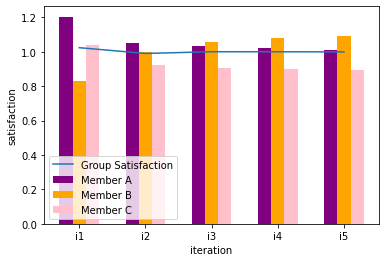

<Figure size 2400x1600 with 0 Axes>

In [16]:
labels = ['i1', 'i2', 'i3', 'i4', 'i5']
x = np.arange(len(labels))
y1 = [satA1, satA2, satA3, satA4, satA5]
y2 = [satB1, satB2, satB3, satB4, satB5]
y3 = [satC1, satC2, satC3, satC4, satC5]
y4 = [group_sat1, group_sat2, group_sat3, group_sat4, group_sat5]
width = 0.2

# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='purple')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='pink')
plt.plot(labels, y4)
plt.xticks(x, labels)
plt.xlabel("iteration")
plt.ylabel("satisfaction")
plt.legend(["Group Satisfaction","Member A", "Member B", "Member C" ])
plt.figure(figsize=(30, 20), dpi=80)
plt.show()

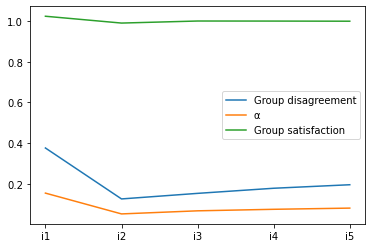

In [17]:
alpha = [alpha1, alpha2, alpha3, alpha4, alpha5]
group_dis = [group_dis1, group_dis2, group_dis3, group_dis4, group_dis5]
plt.plot(labels,group_dis)
plt.plot(labels, alpha)
plt.plot(labels, y4)
plt.legend(["Group disagreement", "α", "Group satisfaction" ])
plt.show()

In [18]:
#overall satisfaction
userATotSat = np.sum(y1)
userBTotSat = np.sum(y2)
userCTotSat = np.sum(y3)

overalSat = (userATotSat + userBTotSat + userCTotSat)/5
print("Overall user satisfaction (5 iteration): ", overalSat)

Overall user satisfaction (5 iteration):  3.0085601765720322


In [19]:
av_dis = np.mean(group_dis)
print("Average group disagreement: ", av_dis)

Average group disagreement:  0.2052587024459882
